# K-nearest predictions

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from scipy import stats
import utils as u
import copy

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

%run utils.py

In [62]:
metaData = u.getAllMetadata()
train = u.getAllTrainData()
test = u.getAllTestData()

In [63]:
###### MISSING VALUES
# area_living
train = u.fillnaReg(train, ['area_total'], 'area_living')

# area_kitchen
train = u.fillnaReg(train, ['area_total', 'area_living'], 'area_kitchen')

# ceiling
train = u.fillnaReg(train, ['stories'], 'ceiling')

In [64]:
############## SETTINGS
test_size = 0.2
random_state_split = 42
features = ["area_total", "ceiling", "latitude", "longitude", "floor", "condition", "bathrooms_shared", 'parking'] 


In [65]:
train.fillna(train.mean(), inplace = True)
test.fillna(test.mean(), inplace = True)
train_data, test_data = train_test_split(train, test_size=test_size, random_state=random_state_split, stratify=np.log(train.price).round())

In [66]:
X_train, y_train = train_data[features], train_data['price']
X_test, y_test = test_data[features], test_data['price']

In [67]:
# def runKNearest(X_train, y_train, X_test, y_test, 
#     n_neighbors = 20, weights='uniform', algorithm='ball_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=None):
#     model = KNeighborsRegressor(
#         n_neighbors=n_neighbors, 
#         weights=weights, 
#         algorithm=algorithm, 
#         leaf_size=leaf_size, 
#         p=p, 
#         metric=metric, 
#         metric_params=metric_params, 
#         n_jobs=n_jobs
#     )
#     model.fit(X_train, y_train)
#     rf_prediction = model.predict(X_test)
#     rf_msle = root_mean_squared_log_error(rf_prediction, y_test)
#     return rf_msle

# def optimizeParam(X_train, y_train, X_test, y_test, variable, start, end, step):
#     x = []
#     y = []
#     for value in range(start, end, step):
#         x.append(value)
#         y.append(runKNearest(X_train, y_train, X_test, y_test, p=value))
#     plt.plot(x, y)
#     plt.xlabel('p parameter values')
#     plt.ylabel('RMLSE')

# def optimizeParam(X_train, y_train, X_test, y_test, variable, values):
#     x = []
#     y = []
#     for value in values:
#         x.append(value)
#         y.append(runKNearest(X_train, y_train, X_test, y_test, algorithm=value))
#     plt.plot(x, y)
#     plt.xlabel('algorithm parameter values')
#     plt.ylabel('RMLSE')

# optimizeParam(X_train, y_train, X_test, y_test, 'algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

In [68]:
model = KNeighborsRegressor(
    n_neighbors=20, 
    weights='uniform', 
    algorithm='ball_tree', 
    leaf_size=30, 
    p=1, 
    metric='minkowski', 
    metric_params=None, 
    n_jobs=None
)

In [69]:
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, p=1)

In [70]:
rf_prediction = model.predict(X_test)
rf_mse = root_mean_squared_log_error(rf_prediction, y_test)
print('Test MSE:', rf_mse)

Test MSE: 0.3547570579787334


Text(0, 0.5, 'Ground Truth')

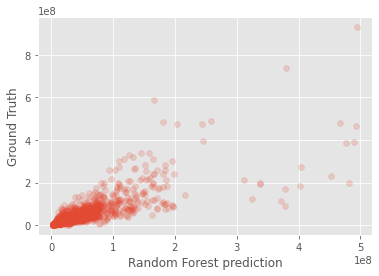

In [71]:
plt.scatter(rf_prediction, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')